# AL samples
1 Logistic PCA
2 NMF results
3 Survival Analysis
4 Age BMPC% dFLC
5 Drug Response

In [1]:
library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2)
library(cowplot)
library(survival)
library(survminer)
library(openxlsx)
library(ggpubr)
library(RColorBrewer)
library("rARPACK")
library("logisticPCA")
source('survplotPCD.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




In [2]:
ALgroups<-read.xlsx('Table S4-re.xlsx', sheet = 1, startRow = 1, colNames = TRUE, rowNames = FALSE)
rownames(ALgroups)<-ALgroups$newID

In [3]:
meta<-read.csv('PCDalllist-wxz0513.csv',header=T)
rownames(meta)<-meta$newID
metaAL<-meta[which(meta$diagnosis=='AL'),]

In [4]:
all<-read.csv('0429-snp-allmut-together-bi.csv')
rownames(all)<-all$X
all$X<-NULL
all<-all[,metaAL$newID]
all<-all[which(rowSums(all)>0.02*67),]

In [5]:
ALifish<-read.csv(file='1207-ALifish.csv')
rownames(ALifish)<-ALifish$X
ALifish$X<-NULL

In [6]:
normal <- CreateSeuratObject(counts =all, project = "normal",min.cells = 1)
normal@meta.data<-cbind(normal@meta.data,metaAL[rownames(normal@meta.data),])
normal@meta.data<-cbind(normal@meta.data,ALgroups[rownames(normal@meta.data),])
normal@meta.data<-cbind(normal@meta.data,ALifish[rownames(normal@meta.data),])
colnames(normal@meta.data)[dim(normal@meta.data)[2]]<-'ifisht1114'
suppressMessages(normal <- ScaleData(normal, features = rownames(all)))
suppressMessages(normal <- RunPCA(normal, features = rownames(all),npcs = 2))

Warning message in print.DimReduc(x = reduction.data, dims = ndims.print, nfeatures = nfeatures.print):
“Only 2 dimensions have been computed.”
Warning message:
“Requested number is larger than the number of available items (56). Setting to 56.”
Warning message:
“Requested number is larger than the number of available items (56). Setting to 56.”


In [7]:
set.seed(42)
X.df <- as.data.frame(t(all))
X <- as.matrix(sapply(X.df, as.numeric))
# Determine m via logisticSVD
logsvd_model = logisticSVD(X, k = 2)
logpca_cv = cv.lpca(X, ks = 2, ms = 1:10)
#write.table(logpca_cv, file.path(args$outdir, "logistic_pca_cv_nll.tsv") ,sep='\t')

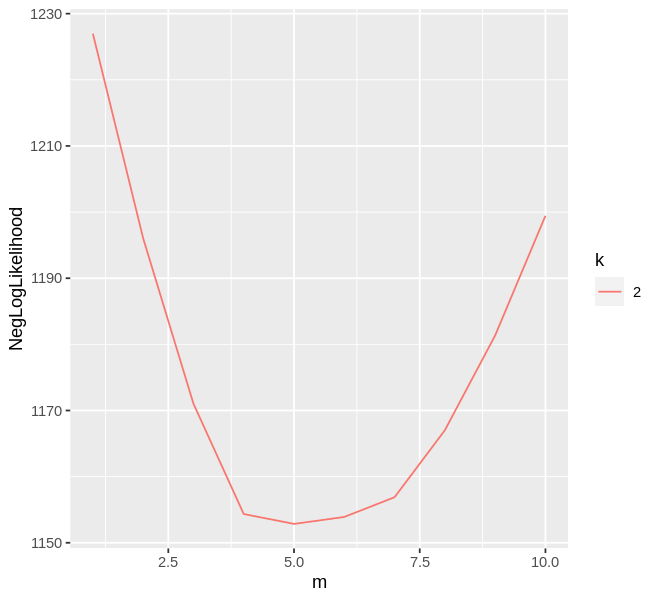

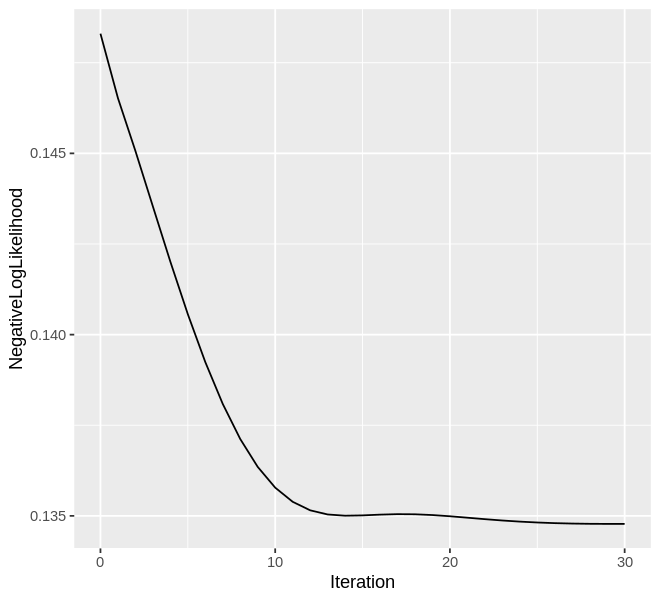

In [8]:
options(repr.plot.height=5,repr.plot.width=5.5)
# Run logistic PCA models (we  use logPCA, not convexLogisticPCA)
logpca_model = logisticPCA(X, k = 2, m = which.min(logpca_cv))
clogpca_model = convexLogisticPCA(X, k = 2, m = which.min(logpca_cv))
plot(logpca_cv)
plot(clogpca_model, type = "trace")

In [9]:
# Write out Results for PCA Loadings & PCA Components
logpca_modelPCs<-as.data.frame(logpca_model$PCs)
rownames(logpca_modelPCs) <- rownames(X.df)
colnames(logpca_modelPCs) <- c('PC_1','PC_2')
normal@reductions$pca@cell.embeddings<-as.matrix(logpca_modelPCs[rownames(normal@meta.data),])
normal@meta.data$center<-substring(normal@meta.data$ID,1,5)

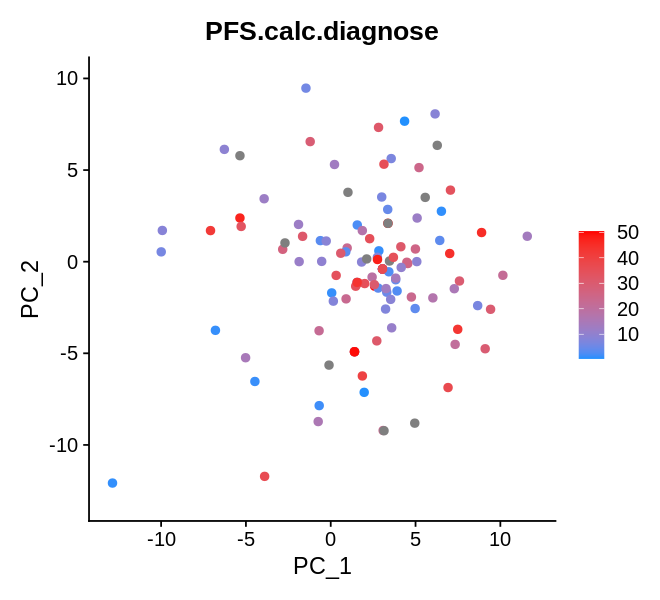

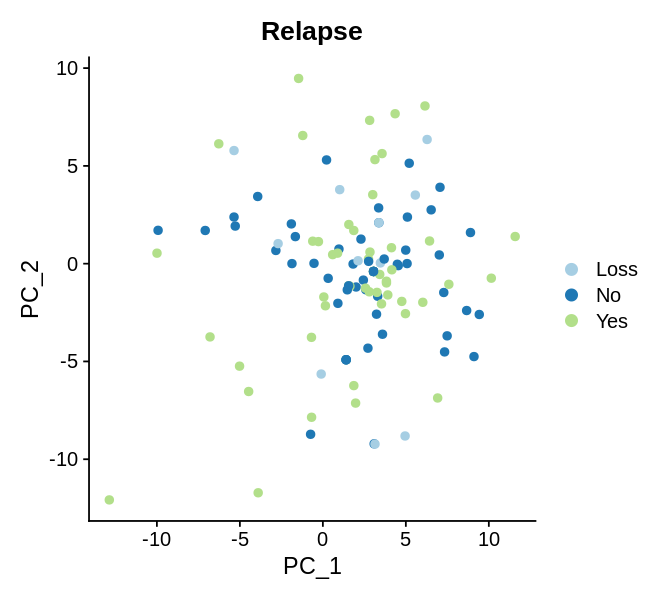

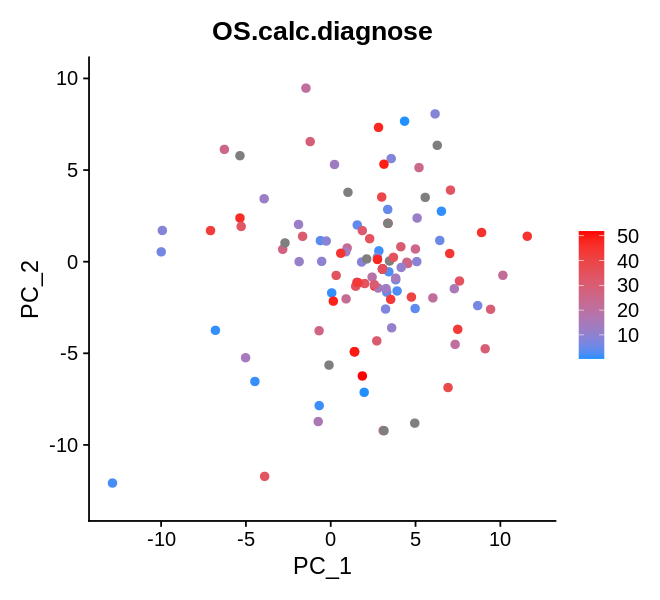

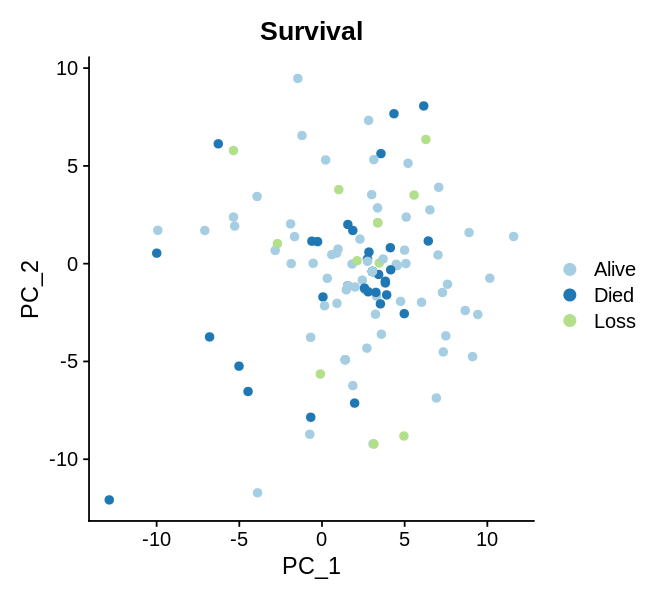

In [10]:
options(repr.plot.height=5,repr.plot.width=5.5)
FeaturePlot(normal,reduction='pca',feature='PFS.calc.diagnose',cols=c('dodgerblue','red'),pt.size=2)
DimPlot(normal, reduction = "pca",group.by='Relapse',label=F,pt.size=2,cols=brewer.pal(3,"Paired"))
FeaturePlot(normal,reduction='pca',feature='OS.calc.diagnose',cols=c('dodgerblue','red'),pt.size=2)
DimPlot(normal, reduction = "pca",group.by='Survival',label=F,pt.size=2,cols=brewer.pal(3,"Paired"))

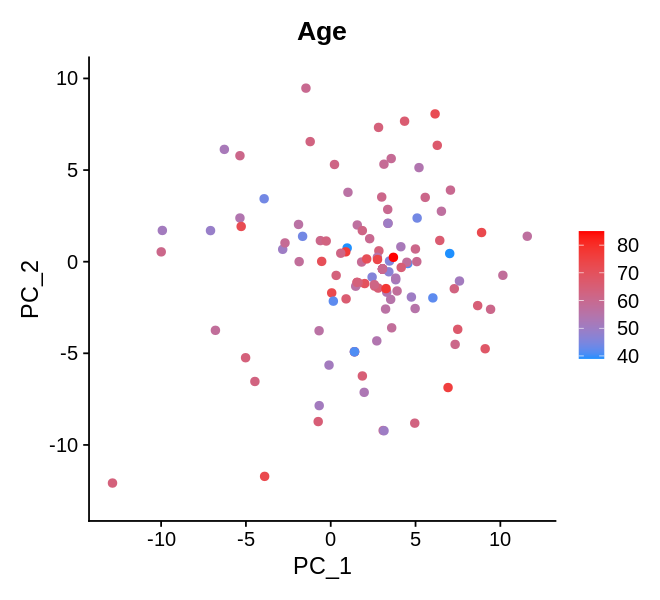

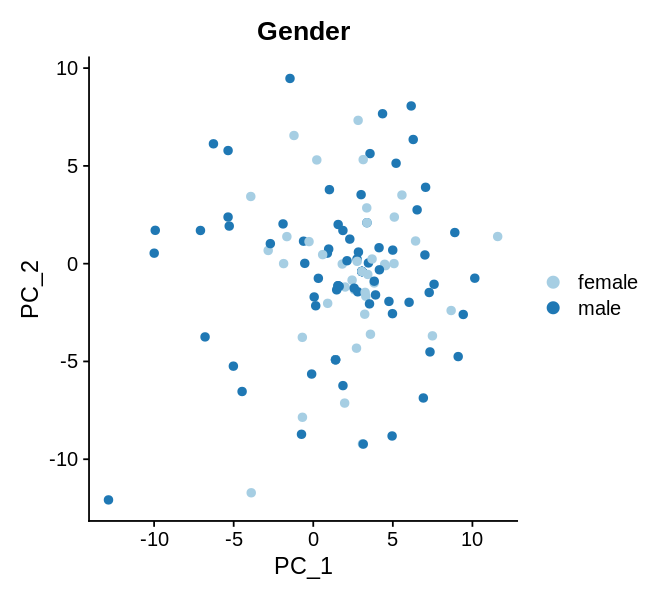

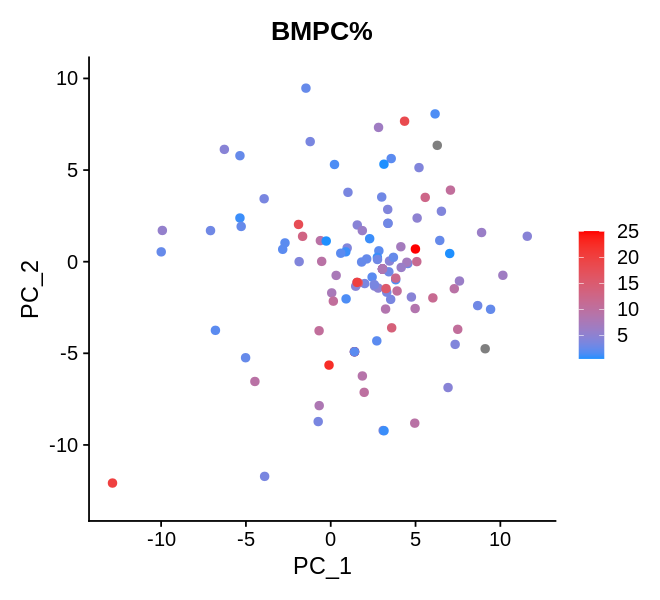

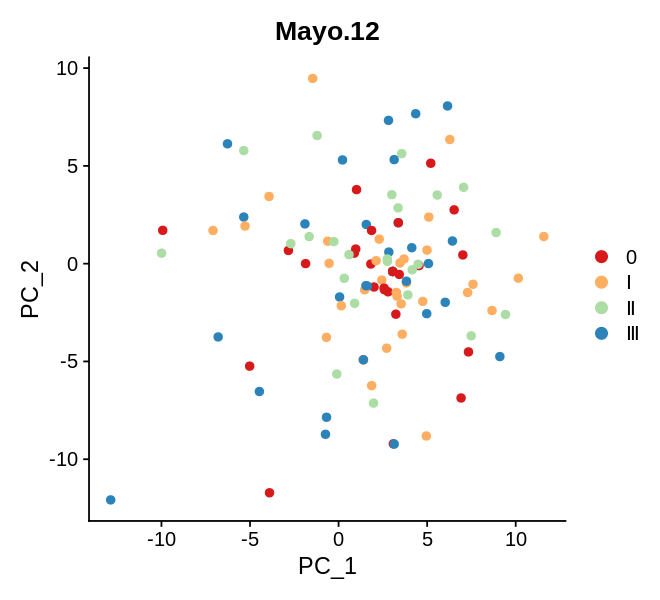

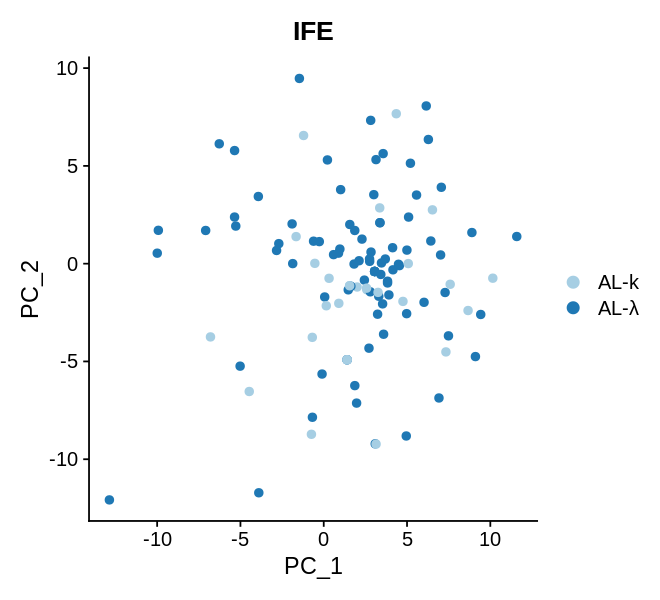

In [11]:
options(repr.plot.height=5,repr.plot.width=5.5)
FeaturePlot(normal,reduction='pca',feature='Age',cols=c('dodgerblue','red'),pt.size=2)
DimPlot(normal, reduction = "pca",group.by='Gender',label=F,pt.size=2,cols=brewer.pal(3,"Paired"))
FeaturePlot(normal,reduction='pca',feature='BMPC%',cols=c('dodgerblue','red'),pt.size=2)
DimPlot(normal, reduction = "pca",group.by='Mayo.12',label=F,pt.size=2,cols=brewer.pal(4,"Spectral"))
DimPlot(normal, reduction = "pca",group.by='IFE',label=F,pt.size=2,cols=brewer.pal(3,"Paired"))

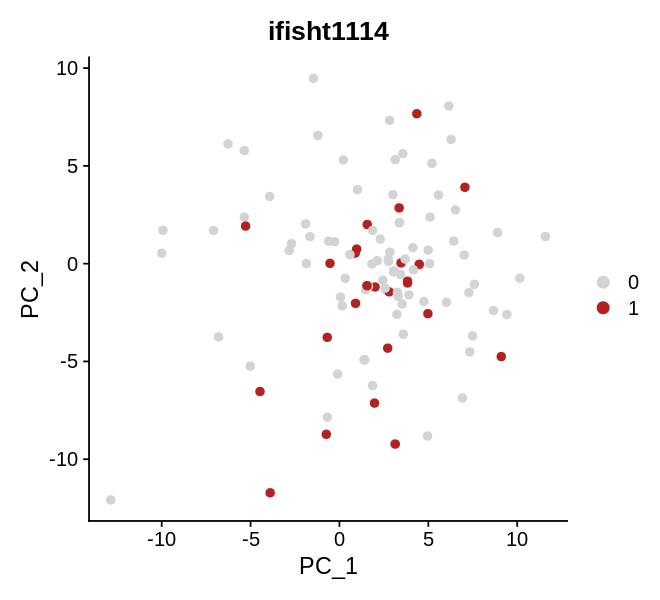

In [12]:
options(repr.plot.height=5,repr.plot.width=5.5)
DimPlot(normal, reduction = "pca",group.by='ifisht1114',label=F,pt.size=2,cols=c('lightgrey','firebrick'))

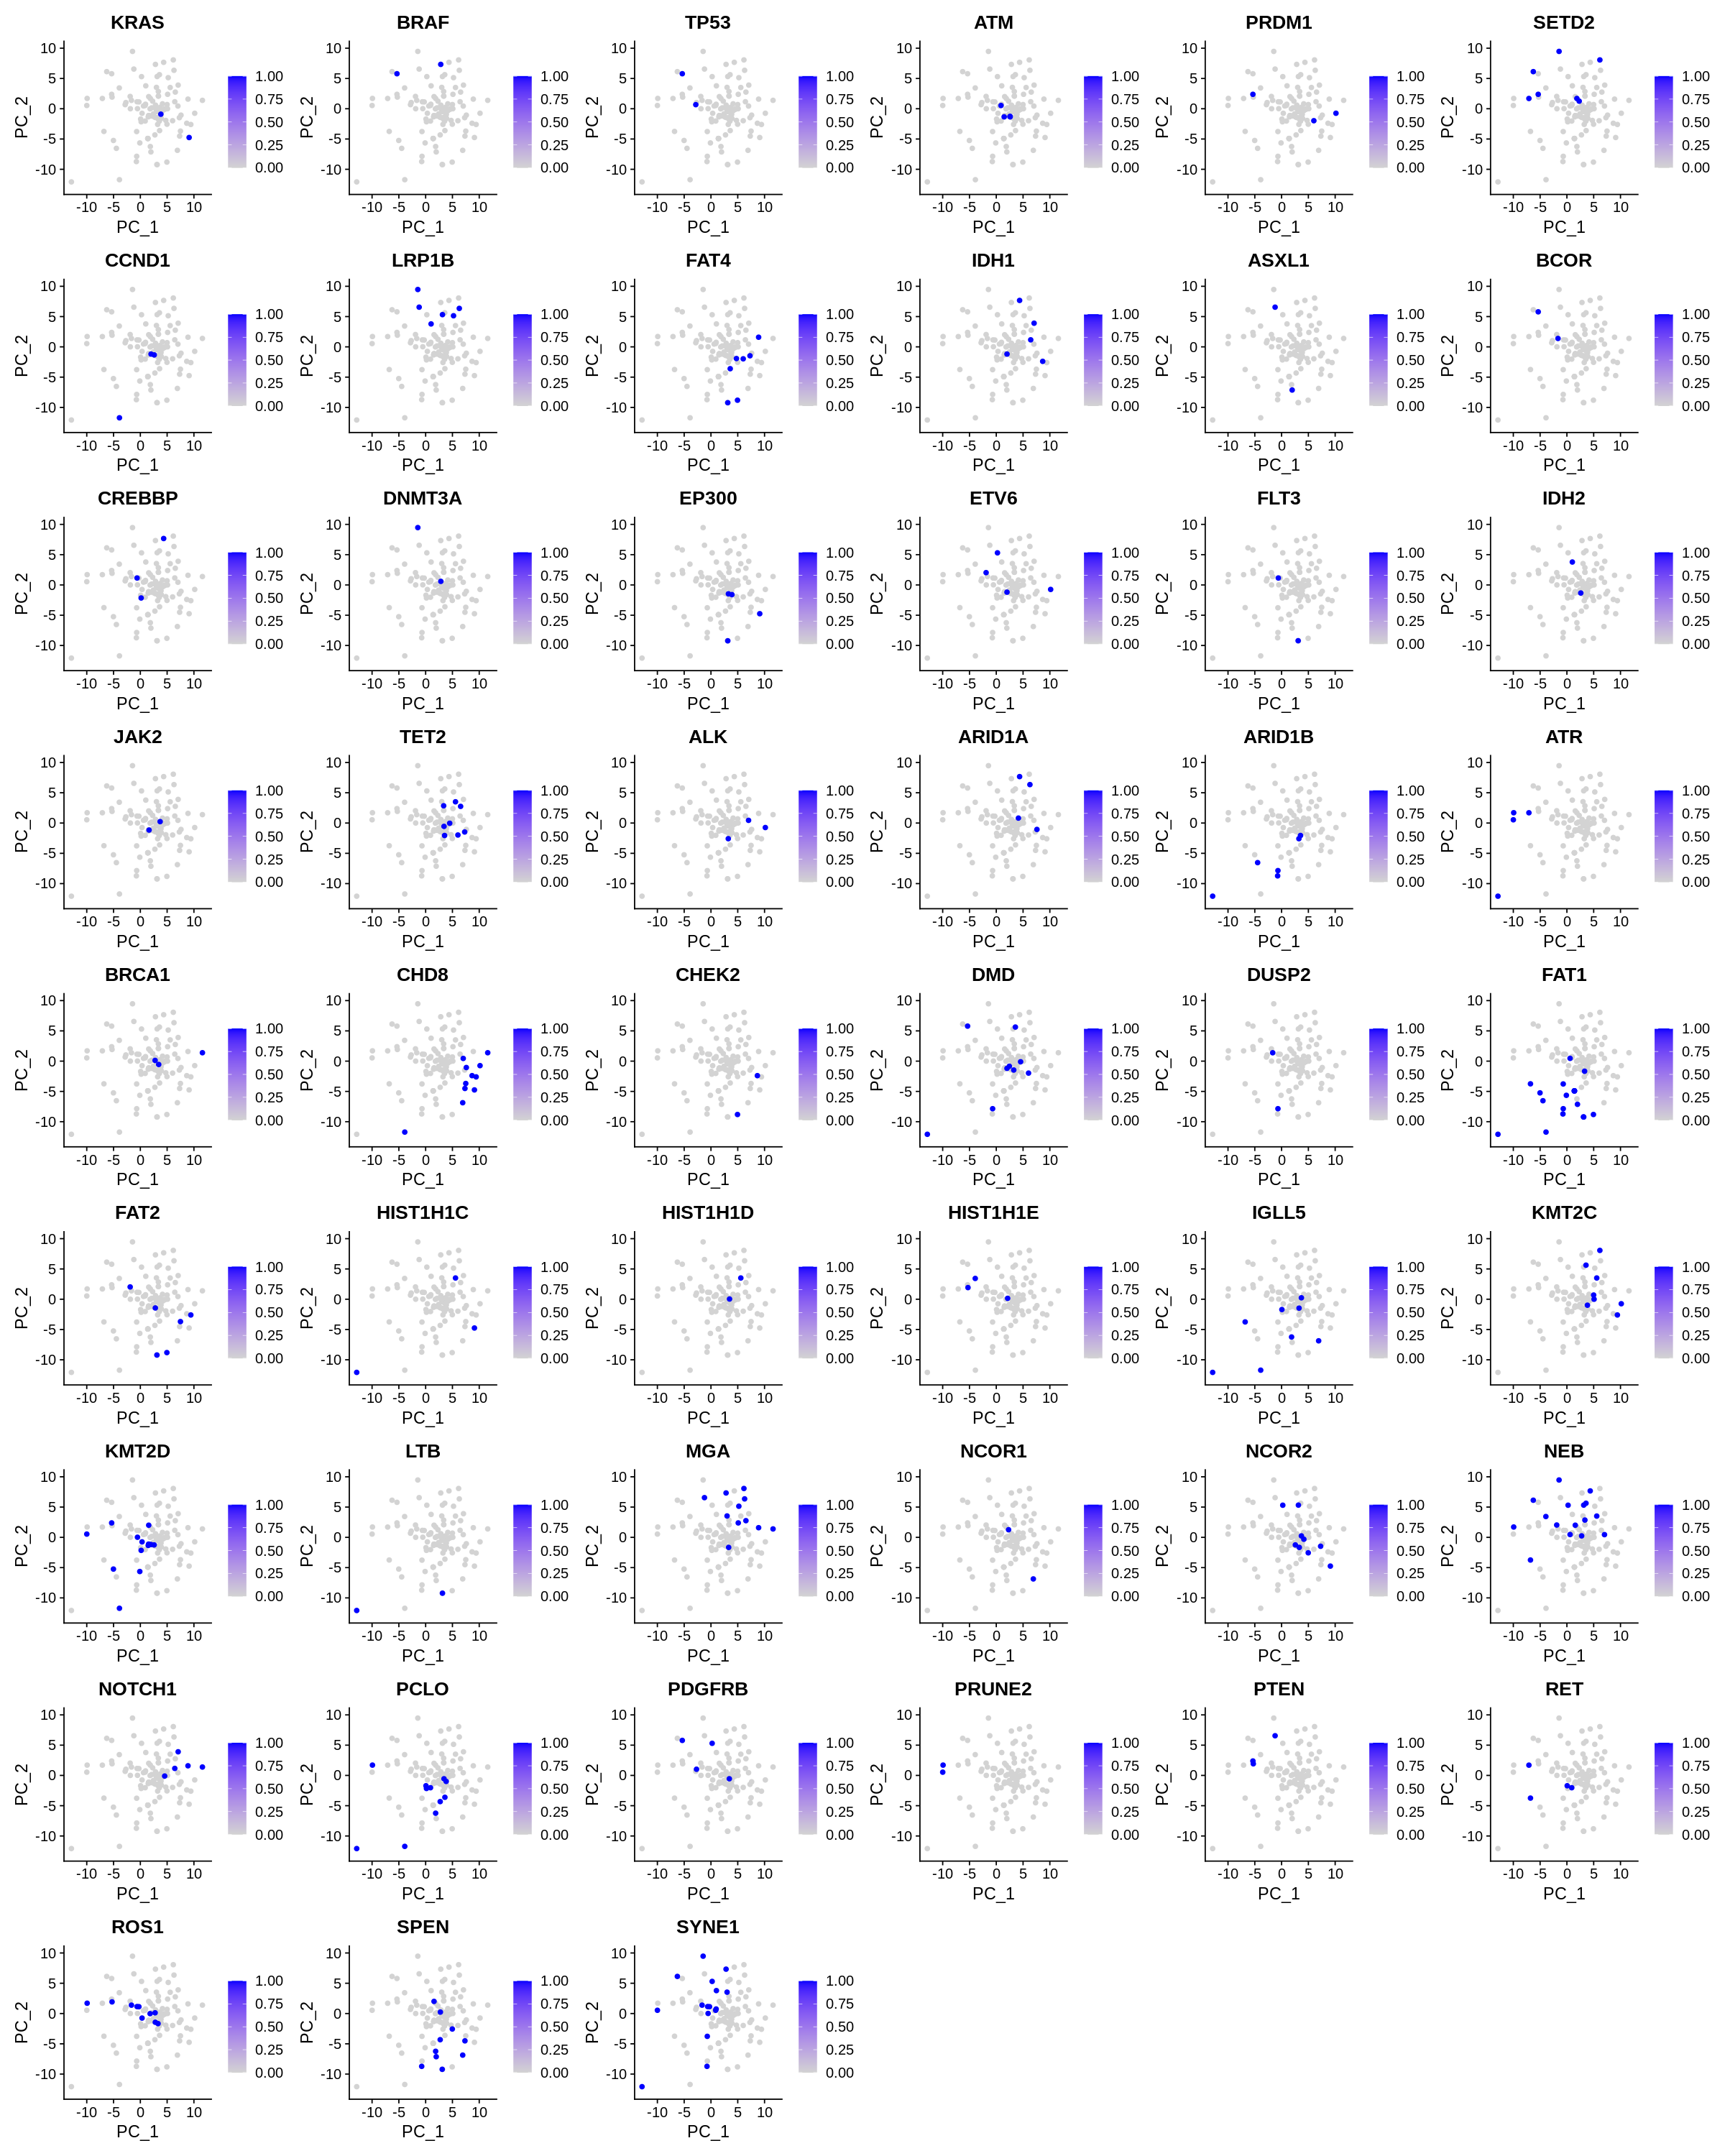

In [13]:
options(repr.plot.height=25,repr.plot.width=20)
NMCHIP<-read.csv('NMCHIP.csv',header=T)
FeaturePlot(normal, reduction = "pca",features=intersect(rownames(all),NMCHIP$Gene),label=F,pt.size=1.5,order=T,ncol=6)

In [14]:
dim(all)
write.table(as.data.frame(t(all)), file='test_AL_loh.tsv', quote=FALSE, sep='\t', col.names = NA)

[1]  56 121

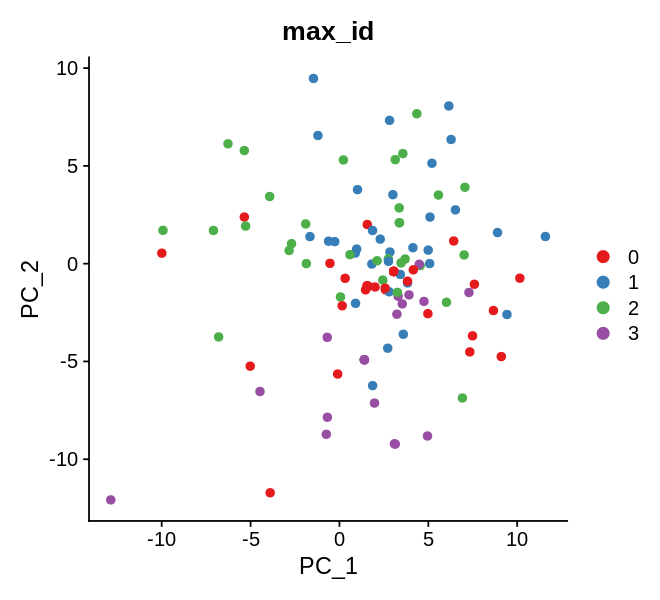

In [15]:
nmf<-read.delim( "./downsampling/H_bnmf_k6_4.tsv" )
rownames(nmf)<-nmf$X
normal@meta.data<-cbind(normal@meta.data,nmf[rownames(normal@meta.data),])
options(repr.plot.height=5,repr.plot.width=5.5)
DimPlot(normal, reduction = "pca",group.by='max_id',label=F,pt.size=2,cols=gsub('#FFFF33','grey',brewer.pal(7,"Set1")))

In [16]:
ALgroups$max_id<-nmf[ALgroups$newID,]$max_id
table(ALgroups$max_id)


 0  1  2  3 
35 33 32 21 

Warning message in survplotPCD(data = ALgroups, status = "Relapse", time = "PFS.calc.diagnose", :
“NAs introduced by coercion”


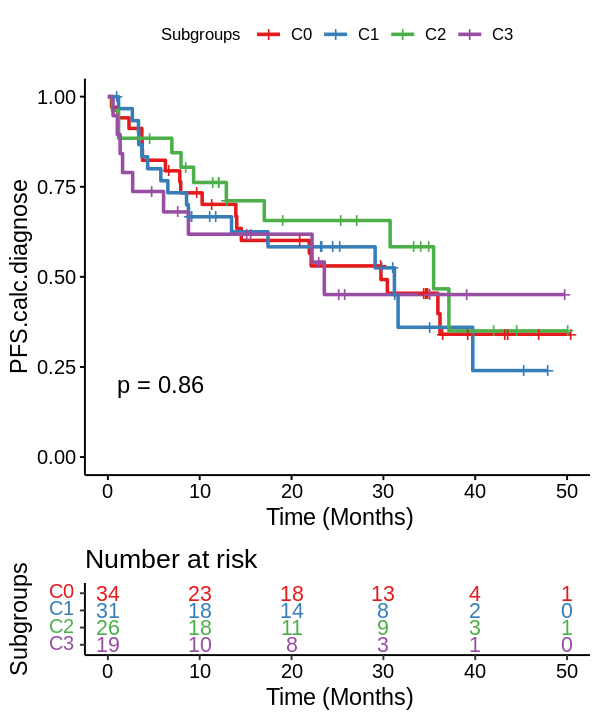

In [17]:
suppressMessages(p<-survplotPCD(data=ALgroups,status='Relapse',
                             time='PFS.calc.diagnose',negative='No',positive='Yes',
                             group='max_id',labels=c("C0",'C1',"C2",'C3')))
p

Warning message in survplotPCD(data = ALgroups, status = "Survival", time = "OS.calc.diagnose", :
“NAs introduced by coercion”


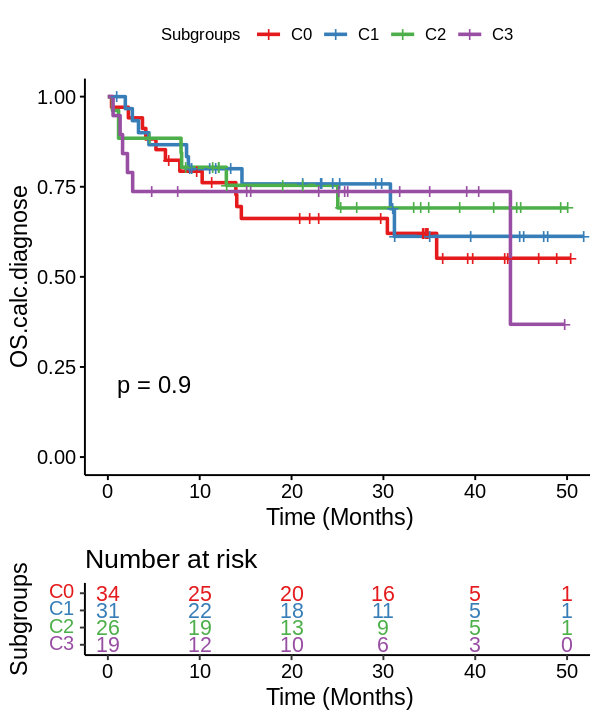

In [18]:
suppressMessages(p<-survplotPCD(data=ALgroups,status='Survival',
                             time='OS.calc.diagnose',negative='Alive',positive='Died',
                                                group='max_id',labels=c("C0",'C1',"C2",'C3')))
p

In [19]:
table(ALgroups$Mayo.12)


 0  Ⅰ  Ⅱ  Ⅲ 
26 36 25 34 

In [20]:
ALgroupslate1<-ALgroups[which(ALgroups$Mayo.12=="Ⅲ"),]
ALgroupslate2<-ALgroups[which(ALgroups$Mayo.12=="Ⅱ"),]
ALgroupslate<-rbind(ALgroupslate2,ALgroupslate1)

Warning message in survplotPCD(data = ALgroupslate, status = "Relapse", time = "PFS.calc.diagnose", :
“NAs introduced by coercion”


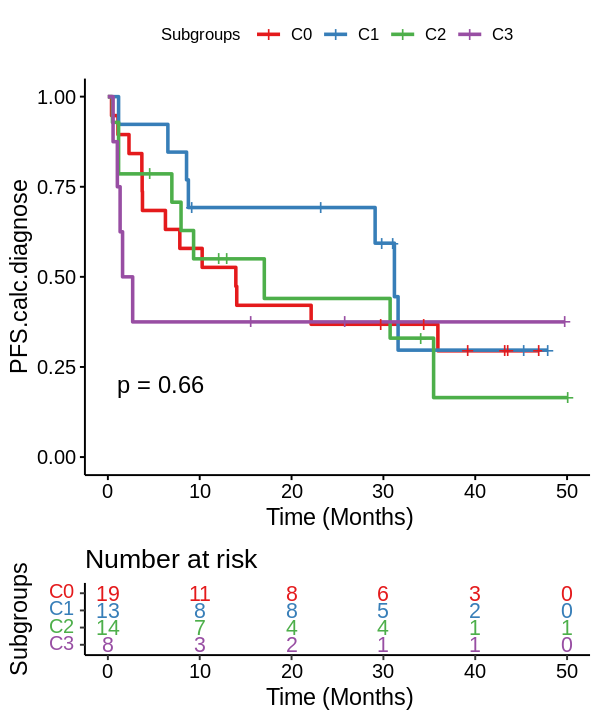

In [21]:
suppressMessages(p<-survplotPCD(data=ALgroupslate,status='Relapse',
                             time='PFS.calc.diagnose',negative='No',positive='Yes',
                                            group='max_id',labels=c("C0",'C1',"C2",'C3')))
p

Warning message in survplotPCD(data = ALgroupslate, status = "Survival", time = "OS.calc.diagnose", :
“NAs introduced by coercion”


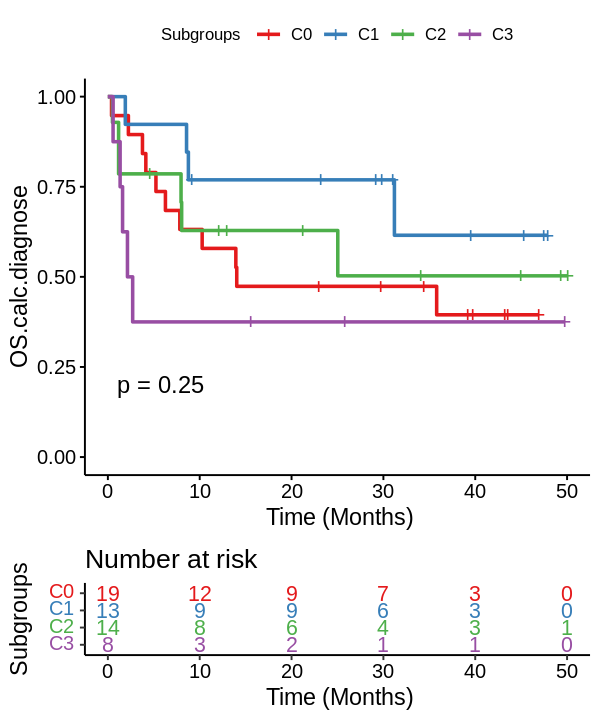

In [22]:
suppressMessages(p<-survplotPCD(data=ALgroupslate,status='Survival',
                             time='OS.calc.diagnose',negative='Alive',positive='Died',
                                            group='max_id',labels=c("C0",'C1',"C2",'C3')))
p

In [23]:
ALgroupsearly1<-ALgroups[which(ALgroups$Mayo.12=="Ⅰ"),]
ALgroupsearly2<-ALgroups[which(ALgroups$Mayo.12=="0"),]
ALgroupsearly<-rbind(ALgroupsearly2,ALgroupsearly1)

Warning message in survplotPCD(data = ALgroupsearly, status = "Relapse", time = "PFS.calc.diagnose", :
“NAs introduced by coercion”


png 
  2

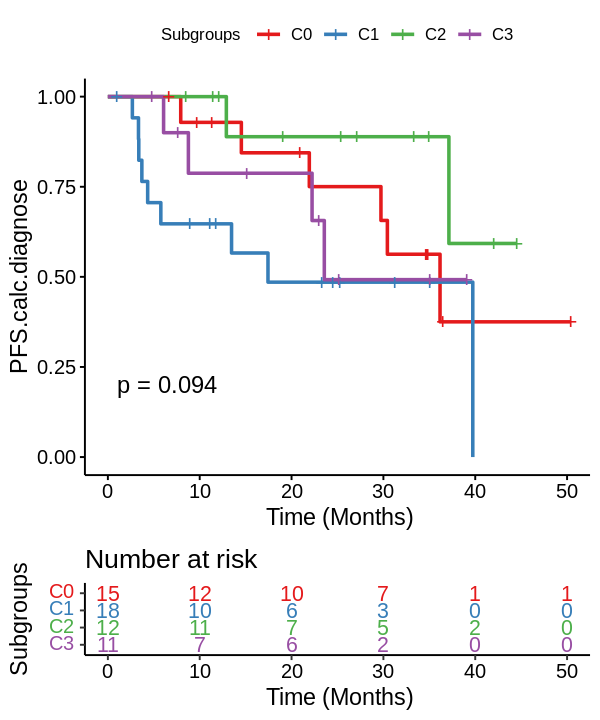

In [24]:
suppressMessages(p<-survplotPCD(data=ALgroupsearly,status='Relapse',
                             time='PFS.calc.diagnose',negative='No',positive='Yes',
                                            group='max_id',labels=c("C0",'C1',"C2",'C3')))
p
pdf(file="AL.pdf",height=6,width=5)
p
dev.off()

In [25]:
ALgroupsearly$max<-ALgroupsearly$'max_id'
ALgroupsearly$max<-gsub('0','others',ALgroupsearly$max)
ALgroupsearly$max<-gsub('2','others',ALgroupsearly$max)
ALgroupsearly$max<-gsub('3','others',ALgroupsearly$max)

Warning message in survplotPCD(data = ALgroupsearly, status = "Relapse", time = "PFS.calc.diagnose", :
“NAs introduced by coercion”


png 
  2

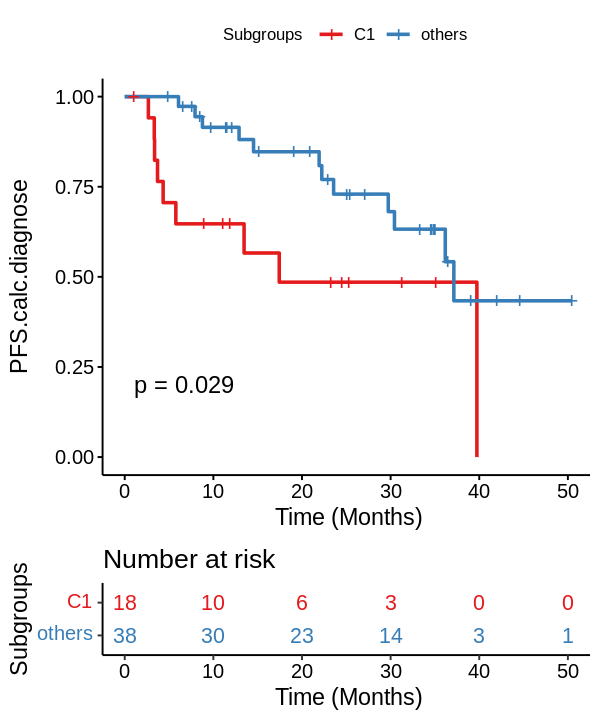

In [26]:
suppressMessages(p<-survplotPCD(data=ALgroupsearly,status='Relapse',
                             time='PFS.calc.diagnose',negative='No',positive='Yes',
                                            group='max',labels=c('C1',"others")))
p
pdf(file="ALothers.pdf",height=6,width=5)
p
dev.off()

Warning message in survplotPCD(data = ALgroupsearly, status = "Survival", time = "OS.calc.diagnose", :
“NAs introduced by coercion”


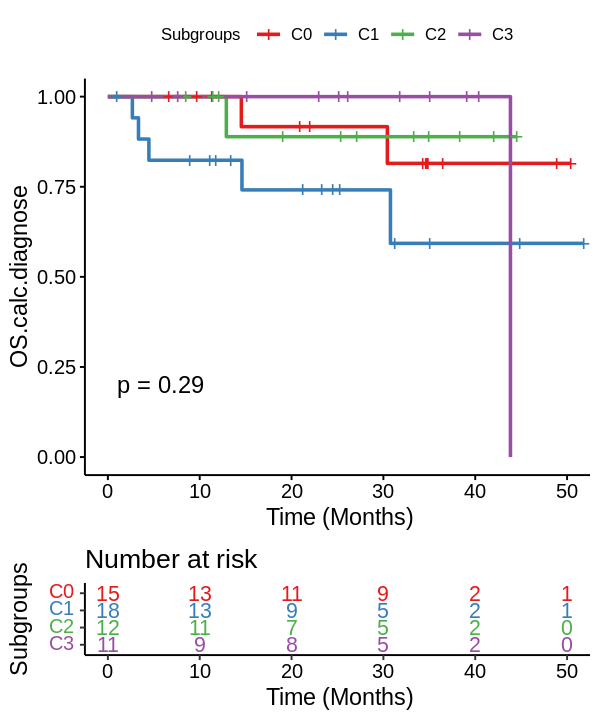

In [27]:
suppressMessages(p<-survplotPCD(data=ALgroupsearly,status='Survival',
                             time='OS.calc.diagnose',negative='Alive',positive='Died',
                                            group='max_id',labels=c("C0",'C1',"C2",'C3')))
p

Warning message in wilcox.test.default(c(64, 57, 69, 65, 64, 55, 65, 63, 61, 53, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(64, 57, 69, 65, 64, 55, 65, 63, 61, 53, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(64, 57, 69, 65, 64, 55, 65, 63, 61, 53, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(57, 47, 72, 60, 61, 44, 58, 64, 77, 51, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(57, 47, 72, 60, 61, 44, 58, 64, 77, 51, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(66, 73, 51, 44, 60, 59, 78, 55, 46, 58, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(64, 57, 69, 65, 64, 55, 65, 63, 61, 53, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(64, 57, 69, 65, 64, 55, 65, 63, 61, 53, :
“cannot compute exact p-value with ties”
Warning 

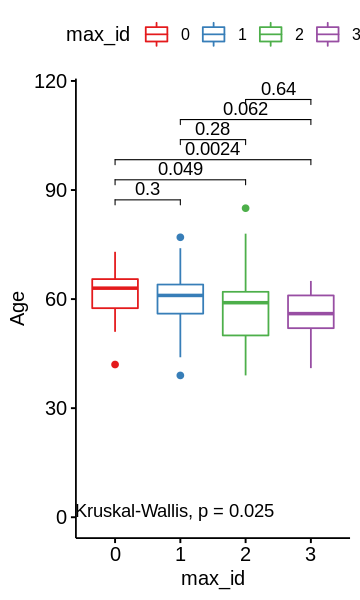

In [28]:
options(repr.plot.height=5,repr.plot.width=3)
ggboxplot(ALgroups, x="max_id", y="Age", color = "max_id")+
  stat_compare_means(label.y = 0)+
 scale_color_brewer(palette='Set1')+
stat_compare_means(comparisons = list( c("0", "1") , c("0", "2"),c("0", "3"),c("1", "2") , c("1", "3"),c("2", "3")))
ggsave(filename="AL1.pdf",height=5,width=3)

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_compare_means).”
Warning message:
“Removed 2 rows containing non-finite values (stat_signif).”
Warning message in wilcox.test.default(c(3.5, 1.5, 7.5, 6, 2.5, 8.5, 3, 7, 2.5, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(3.5, 1.5, 7.5, 6, 2.5, 8.5, 3, 7, 2.5, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(3.5, 1.5, 7.5, 6, 2.5, 8.5, 3, 7, 2.5, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(4, 3, 1.5, 11.5, 9.5, 5, 14, 2, 1, 1.5, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(4, 3, 1.5, 11.5, 9.5, 5, 14, 2, 1, 1.5, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(18.5, 7.5, 5.5, 3.5, 4, 2, 15.5, 1, 2, :
“cannot compute exact p-value with ties”
Warning message:
“

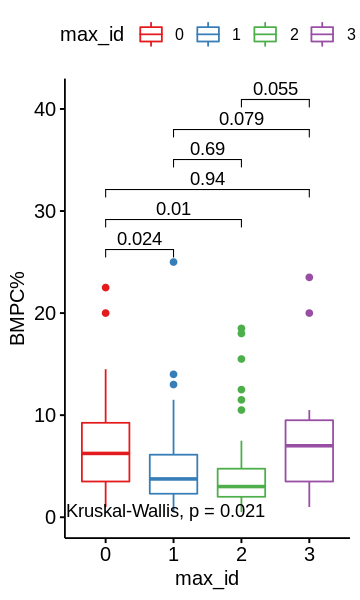

In [29]:
ggboxplot(ALgroups, x="max_id", y="BMPC%", color = "max_id")+
  stat_compare_means(label.y = 0)+
 scale_color_brewer(palette='Set1')+
stat_compare_means(comparisons = list( c("0", "1") , c("0", "2"),c("0", "3"),c("1", "2") , c("1", "3"),c("2", "3")))
ggsave(filename="AL2.pdf",height=5,width=3)

Warning message in wilcox.test.default(c(47.3, 262.8, 734, 136.39, 11.9, 370, 146.2, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(47.3, 262.8, 734, 136.39, 11.9, 370, 146.2, :
“cannot compute exact p-value with ties”


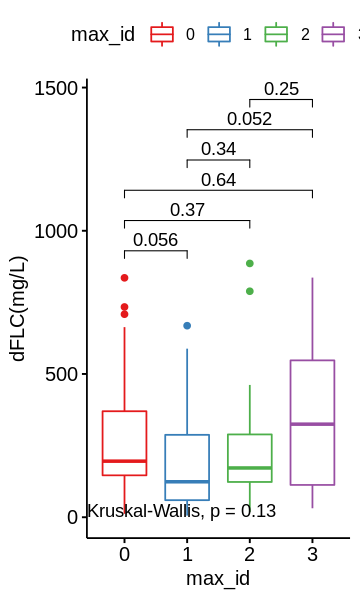

In [30]:
ALgroups2<-ALgroups[which(ALgroups$"dFLC(mg/L)"<1000),]
ggboxplot(ALgroups2, x="max_id", y="dFLC(mg/L)", color = "max_id")+
  stat_compare_means(label.y = 0)+
scale_color_brewer(palette='Set1')+
stat_compare_means(comparisons = list( c("0", "1") , c("0", "2"),c("0", "3"),c("1", "2") , c("1", "3"),c("2", "3")))
ggsave(filename="AL3.pdf",height=5,width=3)

In [31]:
table(ALgroups$Therapy.1st)


   ASCT      BD     BRD Dara+BD Dara+VD      ID      MD     TCD     VCD      VD 
      1       1       2       3       1       1       3       1      58       6 
    VRD 
      2 

In [32]:
ALgroupsVCD<-ALgroups[which(ALgroups$Therapy.1st=='VCD'),]
responsevcd<-as.data.frame(table(ALgroupsVCD[,c('Response.1st','max_id')]))
responsevcd<-responsevcd[which(responsevcd$Response.1st	!='unevaluable'),]
responsevcd

,Response.1st,max_id,Freq
,<fct>,<fct>,<int>
1,CR,0,4
2,NR/SD,0,4
3,PR,0,2
5,VGPR,0,2
6,CR,1,4
7,NR/SD,1,3
8,PR,1,4
10,VGPR,1,5
11,CR,2,3


In [33]:
c0<-responsevcd[which(responsevcd$'max_id'=='0'),]
c1<-responsevcd[which(responsevcd$'max_id'=='1'),]
c2<-responsevcd[which(responsevcd$'max_id'=='2'),]
c3<-responsevcd[which(responsevcd$'max_id'=='3'),]
c0$Freq<-c0$Freq/sum(c0$Freq)
c1$Freq<-c1$Freq/sum(c1$Freq)
c2$Freq<-c2$Freq/sum(c2$Freq)
c3$Freq<-c3$Freq/sum(c3$Freq)
stackvcd<-rbind(c0,c1,c2,c3)
stackvcd

,Response.1st,max_id,Freq
,<fct>,<fct>,<dbl>
1,CR,0,0.3333333
2,NR/SD,0,0.3333333
3,PR,0,0.1666667
5,VGPR,0,0.1666667
6,CR,1,0.2500000
7,NR/SD,1,0.1875000
8,PR,1,0.2500000
10,VGPR,1,0.3125000
11,CR,2,0.3000000


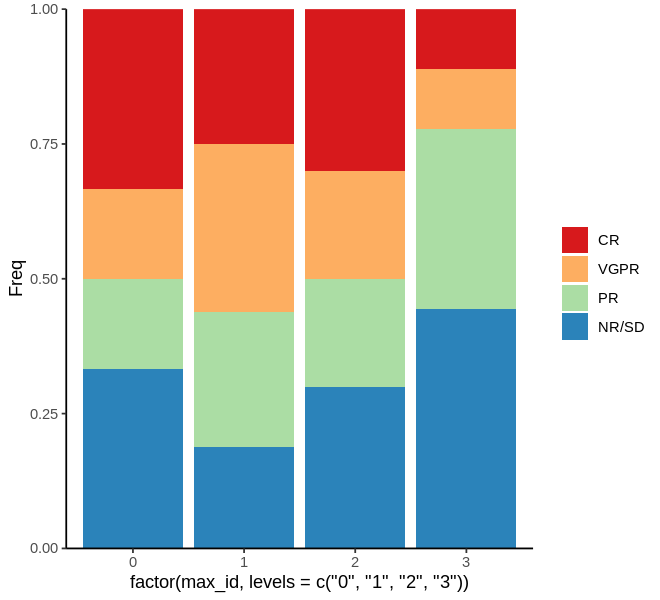

In [34]:
library(ggplot2)
options(repr.plot.height=5,repr.plot.width=5.5)
ggplot(stackvcd, aes(x=factor(max_id,levels=c('0','1','2','3')),y=Freq,fill=factor(Response.1st,levels=c('CR','VGPR','PR','NR/SD',"unevaluable")))) +
  geom_bar(stat="identity") +
  scale_y_continuous(expand=c(0,0))+
 scale_fill_brewer(palette = "Spectral")+
  theme_classic()+
theme(legend.position = "right")+
 guides(fill=guide_legend(title=NULL))
ggsave(filename="VCD.pdf",height=5,width=5.5)